# Experiments without lower limit on seuqence length when adding features

Comparing random vs non-random sequences lengths.

A random sequence length means that each sequence's length is picked randomly from $U[max(L-5,1), L)$ where L is the current sequence length.

A new feature is added to the network if these conditions are met:
- 100k timesteps have passed since it was last added (cfg: features_min_timesteps)
- running_accuracy < 0.9 (cfg: features_acc_thresh)

Not added here (too lazy now...) are previous experiments with an additional condition that the current sequence length L should be > num_layers/2. The randomized sequences achieved crclm of 4 whereas the non-randomized ones did somewhat well until they exploded. Best was 160+ (and ongoing) with lower lr of 3e-5.

In [1]:
import mariadb
import sys
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# JupyterLab renderer support
#jupyter labextension install jupyterlab-plotly@4.14.3

# OPTIONAL: Jupyter widgets extension
#jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.14.3

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'black',
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
plt.rcParams["figure.figsize"] = (10,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})

#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [3]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run", timestep_col_name="datatime"):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            self.conn = mariadb.connect(user="haseebs",
                                        password="",
                                        host="localhost",
                                        port=3306,
                                        database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if table_name == "obs_table":
            self.timestep_col_name = "data_timestep"
        else:
            self.timestep_col_name = "datatime"

        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [4]:
db = DbAccessor('hshah1_cpy_env8')
db.get_table('runs', index=False)

,add_features,comment,data_driven_initialization,features_acc_thresh,features_min_timesteps,fix_L_val,name,num_layers,num_new_features,randomize_sequence_length,run,seed,sequence_gap,sparsity,step_size,steps,width
0,true,nominL,false,0.9,100000,0,cpy_env8,10,5,true,0,0,1,0,3e-4,10000000,10
1,true,nominL,false,0.9,100000,0,cpy_env8,10,5,true,1,1,1,0,3e-4,10000000,10
2,true,nominL,false,0.9,100000,0,cpy_env8,10,5,true,2,2,1,0,3e-4,10000000,10
3,true,nominL,false,0.9,100000,0,cpy_env8,10,5,true,3,3,1,0,3e-4,10000000,10
4,true,nominL,false,0.9,100000,0,cpy_env8,10,5,true,4,4,1,0,3e-4,10000000,10
5,true,nominL,false,0.9,100000,0,cpy_env8,10,5,true,5,5,1,0,3e-4,10000000,10
6,true,nominL-rndseq,true,0.9,100000,0,cpy_env8,10,5,true,6,0,1,0,3e-4,10000000,10
7,true,nominL-rndseq,true,0.9,100000,0,cpy_env8,10,5,true,7,1,1,0,3e-4,10000000,10
8,true,nominL-rndseq,true,0.9,100000,0,cpy_env8,10,5,true,8,2,1,0,3e-4,10000000,10
9,true,nominL-rndseq,true,0.9,100000,0,cpy_env8,10,5,true,9,3,1,0,3e-4,10000000,10


Ignore the cfg:data_driven_initialization:true rows. Those are a mistake. Well, all those gradients basically exploded for all runs in first 10k steps, which is strange.

In [5]:
db.get_table('state_table', index=False)

,run,state,state_comments
0,0,finished,
1,1,finished,
2,2,finished,
3,3,finished,
4,4,killed,nan_prediction
5,5,finished,
6,6,killed,nan_prediction
7,7,killed,nan_prediction
8,8,killed,nan_prediction
9,9,killed,nan_prediction


# Randomized Sequence Lengths

The runs are unable to generate new features because theres a condition that the running_accuracy must be less than 0.90. And they are unable to advance to higher sequence length since running_error is not low enough. What a place to be stuck in.... (╯°□°)╯︵ ┻━┻

Only a single run (4) had NaNs

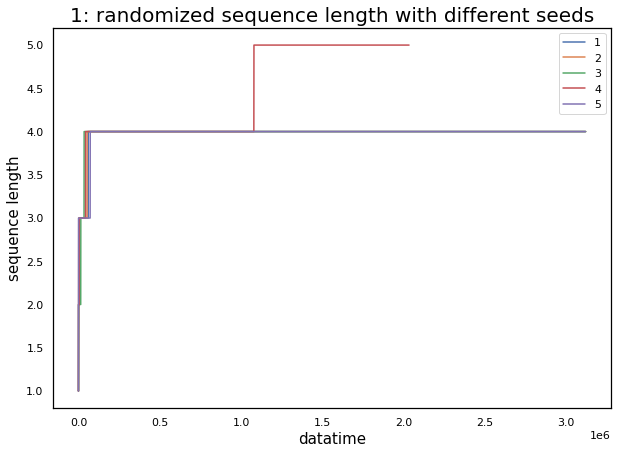

In [6]:


plt.title('1: randomized sequence length with different seeds')
plt.xlabel('datatime')
plt.ylabel('sequence length')
for k in range(1,6):
    plt.plot(db.get_table('error_table', k, 'seq_length'), label=k)
plt.legend()

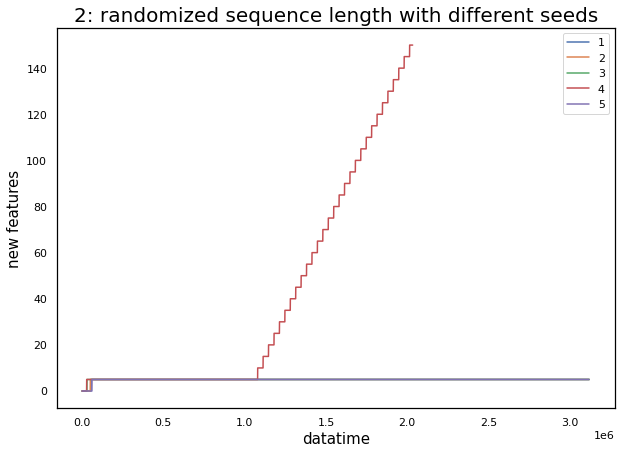

In [7]:
plt.title('2: randomized sequence length with different seeds')
plt.xlabel('datatime')
plt.ylabel('new features')
for k in range(1,6):
    plt.plot(db.get_table('error_table', k, 'new_features'), label=k)
plt.legend()

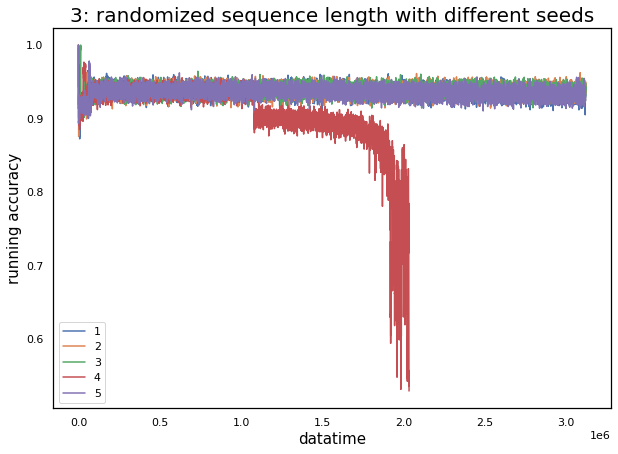

In [8]:
plt.title('3: randomized sequence length with different seeds')
plt.xlabel('datatime')
plt.ylabel('running accuracy')
for k in range(1,6):
    plt.plot(db.get_table('error_table', k, 'accuracy'), label=k)
plt.legend()

# Same experiment, but with non-randomized sequence lengths
4 runs (18-21) ended up with NaNs here. 

The non-crashed ones reached a limit for some reason, not sure why. But the lower lr version (not shown here) was able to go upto a sequence length of 160 (although it was only a single run with good seed).

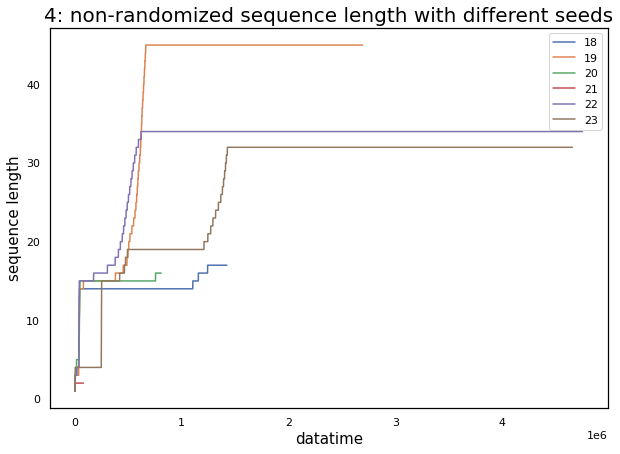

In [9]:
plt.title('4: non-randomized sequence length with different seeds')
plt.xlabel('datatime')
plt.ylabel('sequence length')
for k in range(18,24):
    plt.plot(db.get_table('error_table', k, 'seq_length'), label=k)
plt.legend()

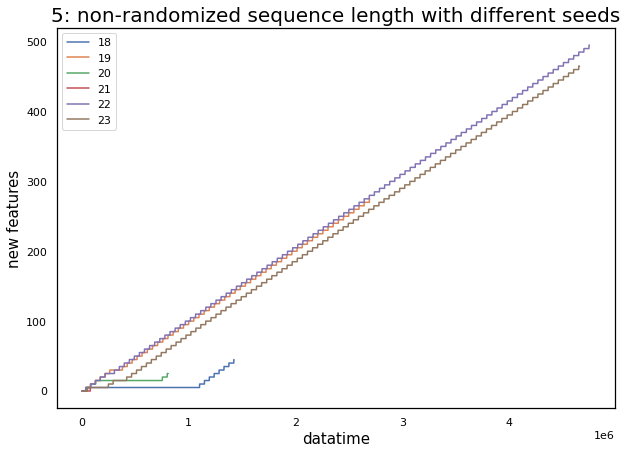

In [10]:
plt.title('5: non-randomized sequence length with different seeds')
plt.xlabel('datatime')
plt.ylabel('new features')
for k in range(18,24):
    plt.plot(db.get_table('error_table', k, 'new_features'), label=k)
plt.legend()

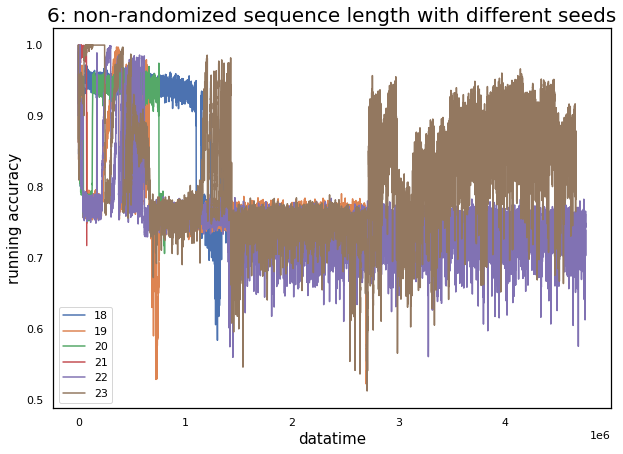

In [11]:
plt.title('6: non-randomized sequence length with different seeds')
plt.xlabel('datatime')
plt.ylabel('running accuracy')
for k in range(18,24):
    plt.plot(db.get_table('error_table', k, 'accuracy'), label=k)
plt.legend()

# Other exp not added
Relaxed the condition of cfg:features_acc_thresh to 0.98 and retrained randomized features. None of them crashed so far and all have been steadily adding features. But all of them are stuck on curclm of 4. Only watched until 2/3rds of regular training. Results on server in hshah1_cpy_env1 db. 

# Other notes
- Is the variance in fig 4 due to bad initialization caused by randomness or bad sequences caused by randomness? Its probably due to bad initialization. But to confirm, could later fix the seed of initialization and evaluate different seeds on sequence generator.
- Relax the condition of cfg:features_acc_thresh on non-randomized sequence L as well, I think that the variance between runs might lower even further? The green and blue proabably wont explode as early.
- Use a good seed on non-randomized sequence L to test some pruning, it seems like a pretty good testbed. Set the pruned weights to 0s.
- Maybe the structure can be made smaller by only adding a feature delay of shortest path + 1 instead of consistent 12 steps of delay, and then adding features more aggressively. But this is probably a solution specific to this problem I think.
- Check the performance of randomized sequence L on wider sparse networks. They seemed to learn better or equally well, but were super slow.